# Import Libraries

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Nov 15 18:08:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import os
import json
from datetime import datetime
import pickle
import time

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torch.nn.functional as F
from torch.utils.data import Subset
import torch.optim.lr_scheduler as lr_scheduler

# Global Variables

In [5]:
BATCH_SIZE = 256
DOWNLOAD = True
CLASSES = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

RANDOM_STATE = 42

# Dataset

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
train_dataset = datasets.CIFAR10(root='drive/MyDrive/data', train=True, download=False)
test_dataset = datasets.CIFAR10(root='drive/MyDrive/data', train=False, download=False)

In [8]:
train_mean = train_dataset.data.mean(axis=(0, 1, 2)) / 255
train_std = train_dataset.data.std(axis=(0, 1, 2)) / 255

test_mean = test_dataset.data.mean(axis=(0, 1, 2)) / 255
test_std = test_dataset.data.std(axis=(0, 1, 2)) / 255

## Data Loading

In [9]:
# Transforming the data to Tensor and Normalizing 3 channels
transform_train = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomCrop(32, 2),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
    ])

# transform_val = transforms.Compose(
#     [
#         transforms.ToTensor(),
#         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
#     ])

transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(test_mean, test_std)
    ])

In [10]:
train_data = datasets.CIFAR10(root='drive/MyDrive/data', train=True, download=True, transform=transform_train)
val_data = datasets.CIFAR10(root='drive/MyDrive/data', train=True, download=True, transform=transform_test)
test_dataset = datasets.CIFAR10(root='drive/MyDrive/data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [11]:
train_idx, val_idx = train_test_split(range(len(train_data)), test_size=0.1)

train_dataset = Subset(train_data, train_idx)
val_dataset = Subset(val_data, val_idx)

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

In [13]:
# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

def plot_images(images, labels, classes, normalize = False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min = image_min, max = image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

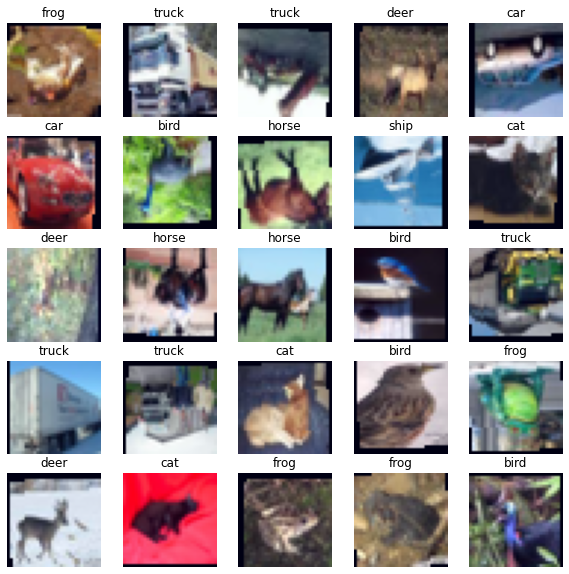

In [14]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = CLASSES

plot_images(images, labels, CLASSES, normalize = True)

In [15]:
images, _ = next(iter(train_dataloader))
print(f"Size of input image: {images[0].shape}")

Size of input image: torch.Size([3, 32, 32])


## Training and Testing

In [16]:
class Module(nn.Module):
    def __init__(self):
        super().__init__()
    
    def loss(self, y_hat, y):
        loss = nn.CrossEntropyLoss()
        return loss(y_hat, y)
    
    def forward(self, X):
        out = self.relu1(self.bn1(self.conv1(X)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out
    
    def optimizer(self, optimizer_type="SGD"):
        assert optimizer_type in ("SGD", "Adam"), f"optimizer_type must be SGD or Adam not {optimizer_type}"
        assert hasattr(self, "lr"), "Learning rate is not defined"
        assert hasattr(self, "weight_decay"), "Weight Decay rate is not defined"
        if optimizer_type == "SGD":
            assert hasattr(self, "momentum"), "Momentum is not defined"
            optimizer = torch.optim.SGD(self.parameters(), lr=self.lr)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
          
        # scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[50], gamma=0.1)
        scheduler = None

        return optimizer, scheduler
    
    def step(self, X ,y):
        y_pred = self(X)
        return self.loss(y_pred, y), y_pred

# Architecture

In [17]:
'''
Option (A) Use identity shortcuts with zero padding to increase channel dimension
Option (B) Use 1x1 convolution to increase channel dimension (projection shortcut)
'''

class PadLayer(nn.Module):
    
    def __init__(self, pad):
        super(PadLayer, self).__init__()
        self.pad = pad
    
    def forward(self, X):
        return self.pad(X)

class BasicConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, projection_option="B"):
        super(BasicConvBlock, self).__init__()
        basic_net = list()
        
        basic_net.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False))
        basic_net.append(nn.BatchNorm2d(out_channels))
        basic_net.append(nn.ReLU(inplace=True))
        basic_net.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False))
        basic_net.append(nn.BatchNorm2d(out_channels))
        
        self.basic_net = nn.Sequential(*basic_net)
        
        shortcut_net = list()
        
        assert projection_option in ("A", "B"), f"projection_option must be either A or B not {projection_option}"
        self.shortcut_net = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            if projection_option == "A":
                padding = out_channels//4
                self.shortcut_net = PadLayer(lambda x: F.pad(x[:, :, ::2, ::2], (0,0, 0,0, padding, padding, 0,0)))
            
            elif projection_option =="B":
                shortcut_net.append(nn.Conv2d(in_channels, 1*out_channels, kernel_size=1, stride=stride, bias=False))
                shortcut_net.append(nn.BatchNorm2d(1*out_channels))
        
                self.shortcut_net = nn.Sequential(*shortcut_net)
    
    def forward(self, X):
        return F.relu(self.basic_net(X) + self.shortcut_net(X)) 

In [18]:
class ResNet(Module):
    def __init__(self, num_blocks, num_classes=10, lr=0.1, momentum=0.9, weight_decay=0.0001):
        super(ResNet, self).__init__()
        
        self.in_channels = 3
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        
        self.conv1 = nn.Conv2d(self.in_channels, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(inplace=True)
        
        self.in_channels = 32
        
        self.layer1 = self.__build_layer(32, num_blocks[0], stride=1)
        
        self.layer2 = self.__build_layer(64, num_blocks[1], stride=2)
        
        self.layer3 = self.__build_layer(128, num_blocks[2], stride=2)
        
        self.layer4 = self.__build_layer(128, num_blocks[3], stride=1)

        self.layer5 = self.__build_layer(256, num_blocks[4], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(256, num_classes)
        
    def __build_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        
        layers = []
        
        for stride in strides:
            layers.append(BasicConvBlock(self.in_channels, out_channels, stride, "A"))
            self.in_channels = out_channels
        
        return nn.Sequential(*layers)

## Trainer Class

In [34]:
class Trainer():
    def __init__(self, epochs=10):
        self.epochs = epochs
        
    def prepare_model(self, model):
        model.trainer = self
        self.model = model
    def save_checkpoint(self, epoch):
      torch.save(self.model, os.path.join("drive/MyDrive/checkpoint", f"model_{epoch + 1}.pt"))
      with open(os.path.join("drive/MyDrive/checkpoint", f"history_{epoch + 1}.json"), 'w') as fp:
        json.dump(self.history, fp)
    
    def load_checkpoint(self, epoch):
      self.model = torch.load(os.path.join("drive/MyDrive/checkpoint", f"model_{epoch + 1}.pt"))
      with open(os.path.join("drive/MyDrive/checkpoint", f"history_{epoch + 1}.json"), "r") as json_file:
        self.history = json.load(json_file)
      
    
    def epoch_time(self, start_time, end_time):
        elapsed_time = start_time - end_time
        elapsed_mins = int(elapsed_time/60)
        elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
        return elapsed_mins, elapsed_secs
    
    def fit(self, train_dataloader, val_dataloader, model):
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.prepare_model(model)
        self.model.to(self.device)
        
        self.optimizer, self.scheduler = self.model.optimizer("Adam")
        
        self.history = {"train": {"loss": [], "accuracy": []}, "val": {"loss": [], "accuracy": []}}
        for epoch in range(0, self.epochs):
            
            start_time = time.time()
            train_loss, train_acc = self.fit_train(train_dataloader)
            val_loss, val_acc = self.fit_val(val_dataloader)
            end_time = time.time()

            # self.scheduler.step()
            
            elapsed_mins, elapsed_secs = self.epoch_time( start_time, end_time)
            
            print(f"<---- Epoch {epoch + 1}: {elapsed_mins}m {elapsed_secs}s ---->")
            print(f"Train Loss: {train_loss}, Train Accuracy: {train_acc}")
            print(f"Val Loss: {val_loss}, Val Accuracy: {val_acc}")
            
            self.history["train"]["loss"].append(train_loss)
            self.history["train"]["accuracy"].append(train_acc)
            self.history["val"]["loss"].append(val_loss)
            self.history["val"]["accuracy"].append(val_acc)

            # if (epoch + 1) % 30 == 0:
            #   self.save_checkpoint(epoch + 1)
        
        self.model.to("cpu")
        
        return self.history
    
    def fit_train(self, train_dataloader):
        self.model.train()
        
        total_loss = 0
        accuracy = 0
        
        batchs = 0
        
        for X, y in train_dataloader:
            batchs += 1
            X, y = X.to(self.device), y.to(self.device)
            
            loss, y_pred = self.model.step(X, y)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
            accuracy += accuracy_score(np.argmax(y_pred.to("cpu").detach().numpy(), axis=1).reshape(-1,1), y.to("cpu").detach().numpy().reshape(-1,1))
            
            del X, y, loss
                
        return total_loss / batchs, accuracy / batchs

    def fit_val(self, val_dataloader):
      assert hasattr(self, "model"), "Model is not yet defined"
      
      self.model.eval()
      total_loss = 0
      accuracy = 0
      
      batchs = 0

      for X, y in val_dataloader:
        batchs += 1
        X, y = X.to(self.device), y.to(self.device)

        with torch.no_grad():
          loss, y_pred = self.model.step(X, y)
          total_loss += loss.item()
          accuracy += accuracy_score(np.argmax(y_pred.to("cpu").detach().numpy(), axis=1).reshape(-1,1), y.to("cpu").detach().numpy().reshape(-1,1))
          del X, y, loss

      return total_loss / batchs, accuracy / batchs

    
    def evaluate(self, test_dataloader):
        
        assert hasattr(self, "model"), "Model is not yet defined"
        if not hasattr(self, "device"):
          self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.model.eval()
        correct = 0
        batchs = 0
        predictions = list()
        labels = list()
        for X, y in test_dataloader:
            batchs += 1
            X, y = X.to(self.device), y.to(self.device)
            
            with torch.no_grad():
                _, y_pred = self.model.step(X, y)
                y_pred = np.argmax(y_pred.to("cpu").detach().numpy(), axis=1).reshape(-1,1)
                y = y.to("cpu").detach().numpy().reshape(-1,1)
                predictions.extend(y_pred)
                labels.extend(y)
                accuracy = accuracy_score(y_pred, y)

                correct += accuracy
            
                del X, y

        
        return correct / batchs, np.array(predictions, dtype=object), np.array(labels, dtype=object)

In [35]:
model = ResNet(num_blocks=[2,2,2,2,2], lr=1e-3)

In [47]:
print(model)

ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicConvBlock(
      (basic_net): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut_net): Sequential()
    )
    (1): BasicConvBlock(
      (basic_net): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReL

In [37]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

3344554

In [38]:
EPOCHS = 30

In [39]:
trainer = Trainer(epochs=EPOCHS)
_ = trainer.fit(train_dataloader, test_dataloader, model)


<---- Epoch 1: 0m -24s ---->
Train Loss: 1.5809996839274059, Train Accuracy: 0.41351118607954546
Val Loss: 1.4053159475326538, Val Accuracy: 0.47890625
<---- Epoch 2: 0m -24s ---->
Train Loss: 1.174387651072307, Train Accuracy: 0.573203125
Val Loss: 1.1232824683189393, Val Accuracy: 0.60859375
<---- Epoch 3: 0m -25s ---->
Train Loss: 0.9939590272578326, Train Accuracy: 0.6444380326704545
Val Loss: 0.9892808482050895, Val Accuracy: 0.64755859375
<---- Epoch 4: 0m -25s ---->
Train Loss: 0.8765198175202716, Train Accuracy: 0.6859348366477273
Val Loss: 0.967013968527317, Val Accuracy: 0.657421875
<---- Epoch 5: 0m -24s ---->
Train Loss: 0.7900740003043955, Train Accuracy: 0.7191628196022727
Val Loss: 0.8884375646710396, Val Accuracy: 0.6953125
<---- Epoch 6: 0m -24s ---->
Train Loss: 0.725772113962607, Train Accuracy: 0.7417924360795454
Val Loss: 0.754200191795826, Val Accuracy: 0.73798828125
<---- Epoch 7: 0m -24s ---->
Train Loss: 0.6722990860315886, Train Accuracy: 0.7631516335227272
Va

In [40]:
history = trainer.history

In [ ]:
# history = trainer.history

In [41]:
acc, y_pred, y = trainer.evaluate(test_dataloader)

In [42]:
print(f"Test Accuracy: {acc}")

Test Accuracy: 0.86875


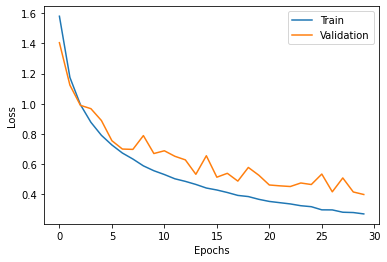

In [43]:
g1 = sns.lineplot(x=range(0, 30), y=history["train"]["loss"])
g2 = sns.lineplot(x=range(0, 30), y=history["val"]["loss"])
# g1.axvline(50)
# g1.axvline(60)
# g1.axvline(70)
# g1.axvline(80)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])
plt.show()

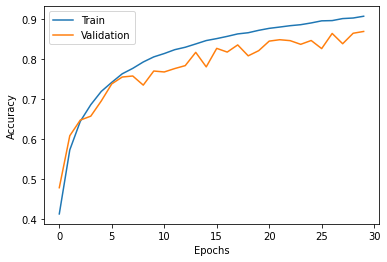

In [45]:
g1 = sns.lineplot(x=range(0, 30), y=history["train"]["accuracy"])
g2 = sns.lineplot(x=range(0, 30), y=history["val"]["accuracy"])
# g1.axvline(50)
# g1.axvline(60)
# g1.axvline(70)
# g1.axvline(80)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])
plt.show()

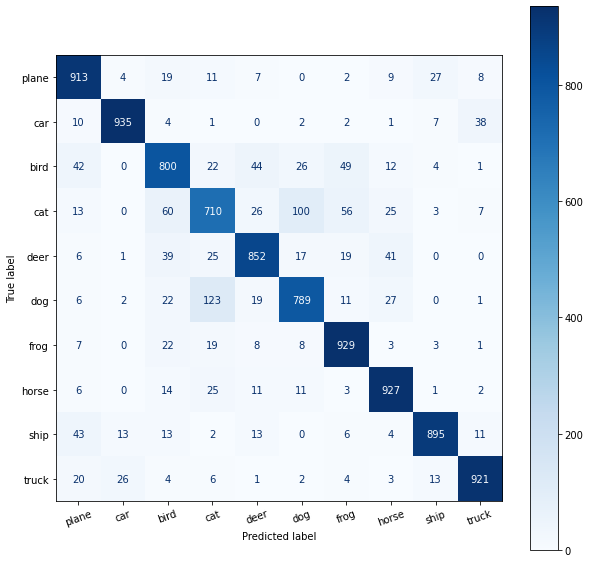

In [46]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1)
cm = confusion_matrix(y.astype(int), y_pred.astype(int))
cm = ConfusionMatrixDisplay(cm, display_labels = CLASSES)
cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
plt.xticks(rotation = 20)
plt.show()